## Classical Methods - Backtesting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hierarchical_risk_parity as hrp

import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [2]:
data_provider = DataProvider()
df_countries, benchmark = data_provider.get_etf_data()
df_returns = df_countries.pct_change().dropna()
days_to_recalculate = data_provider.get_days_to_recalculate()

In [3]:
test_split = int(0.8 * 288)
dates_for_test = days_to_recalculate[test_split:]

### Helper methods

In [4]:
def get_minimum_variance_weights(df_returns, dates_for_test):
    df_weights = pd.DataFrame(index=dates_for_test,
                              columns=df_returns.columns)

    for date in dates_for_test:
        returns_fit = df_returns[:date].iloc[-126:-1]
        if date > pd.to_datetime('2022-03'):
            returns_fit = returns_fit.drop(columns='Russia')
        df_weights.loc[date] = hrp.compute_minimum_variance_weights(
            returns_fit)

    df_weights.fillna(0, inplace=True)
    return df_weights.values

In [5]:
def get_risk_parity_weights(df_returns, dates_for_test):
    df_weights = pd.DataFrame(index=dates_for_test,
                              columns=df_returns.columns)

    for date in dates_for_test:
        returns_fit = df_returns[:date].iloc[-126:-1]
        if date > pd.to_datetime('2022-03'):
            returns_fit = returns_fit.drop(columns='Russia')
        df_weights.loc[date] = hrp.compute_risk_parity_weights(
            returns_fit)

    df_weights.fillna(0, inplace=True)
    return df_weights.values

In [6]:
def get_uniform_variance_weights(df_returns, dates_for_test):
    df_weights = pd.DataFrame(index=dates_for_test,
                              columns=df_returns.columns)

    for date in dates_for_test:
        returns_fit = df_returns[:date].iloc[-126:-1]
        if date > pd.to_datetime('2022-03'):
            returns_fit = returns_fit.drop(columns='Russia')
        df_weights.loc[date] = hrp.compute_unif_weights(
            returns_fit)

    df_weights.fillna(0, inplace=True)
    return df_weights.values

In [7]:
def get_weights_hrp(df_returns, dates_for_test, denoise_method):
    df_weights_hrp = pd.DataFrame(index=dates_for_test,
                                  columns=df_returns.columns)

    for date in dates_for_test:
        returns_fit = df_returns[:date].iloc[-126:-1]
        if date > pd.to_datetime('2022-03'):
            returns_fit = returns_fit.drop(columns='Russia')
        df_weights_hrp.loc[date] = hrp.compute_HRP_weights(
            returns_fit, denoise_method=denoise_method)

    df_weights_hrp.fillna(0, inplace=True)
    return df_weights_hrp.values

### Backtesting

In [8]:
os.chdir(os.path.expanduser('../models'))
from helper_functions import calculate_returns_for_predictions, calculate_metrics

In [9]:
benchmark_test = benchmark[dates_for_test[0]:]
benchmark_returns = np.log(benchmark_test).diff().dropna()
cum_benchmark_returns = (1 + benchmark_returns).cumprod() - 1
cum_benchmark_returns.loc[dates_for_test[0]] = 0
cum_benchmark_returns.sort_index(inplace=True)

In [10]:
dates_for_test.insert(29, df_countries.index.values[-1])
df_prices_test = df_countries[dates_for_test[0]:]
df_returns_test = np.log(df_prices_test).diff().fillna(0)

In [11]:
weights_min_var = get_minimum_variance_weights(df_returns, dates_for_test)
total_returns_min_var, cum_total_returns_min_var = calculate_returns_for_predictions(
    weights_min_var, dates_for_test, df_returns_test)

In [12]:
weights_risk_parity = get_risk_parity_weights(df_returns, dates_for_test)
total_returns_risk_parity, cum_total_returns_risk_parity = calculate_returns_for_predictions(
    weights_risk_parity, dates_for_test, df_returns_test)

In [13]:
weights_uniform_variance = get_uniform_variance_weights(df_returns, dates_for_test)
total_returns_uniform_variance, cum_total_returns_uniform_variance = calculate_returns_for_predictions(
    weights_uniform_variance, dates_for_test, df_returns_test)

In [14]:
weights_hrp = get_weights_hrp(df_returns, dates_for_test, denoise_method=0)
total_returns_hrp, cum_total_returns_hrp = calculate_returns_for_predictions(
    weights_hrp, dates_for_test, df_returns_test)

In [15]:
weights_hrp_denoise_v1 = get_weights_hrp(df_returns, dates_for_test, denoise_method=1)
total_returns_hrp_denoise_v1, cum_total_returns_hrp_denoise_v1 = calculate_returns_for_predictions(
    weights_hrp_denoise_v1, dates_for_test, df_returns_test)

In [16]:
weights_hrp_denoise_v2 = get_weights_hrp(df_returns, dates_for_test, denoise_method=2)
total_returns_hrp_denoise_v2, cum_total_returns_hrp_denoise_v2 = calculate_returns_for_predictions(
    weights_hrp_denoise_v2, dates_for_test, df_returns_test)

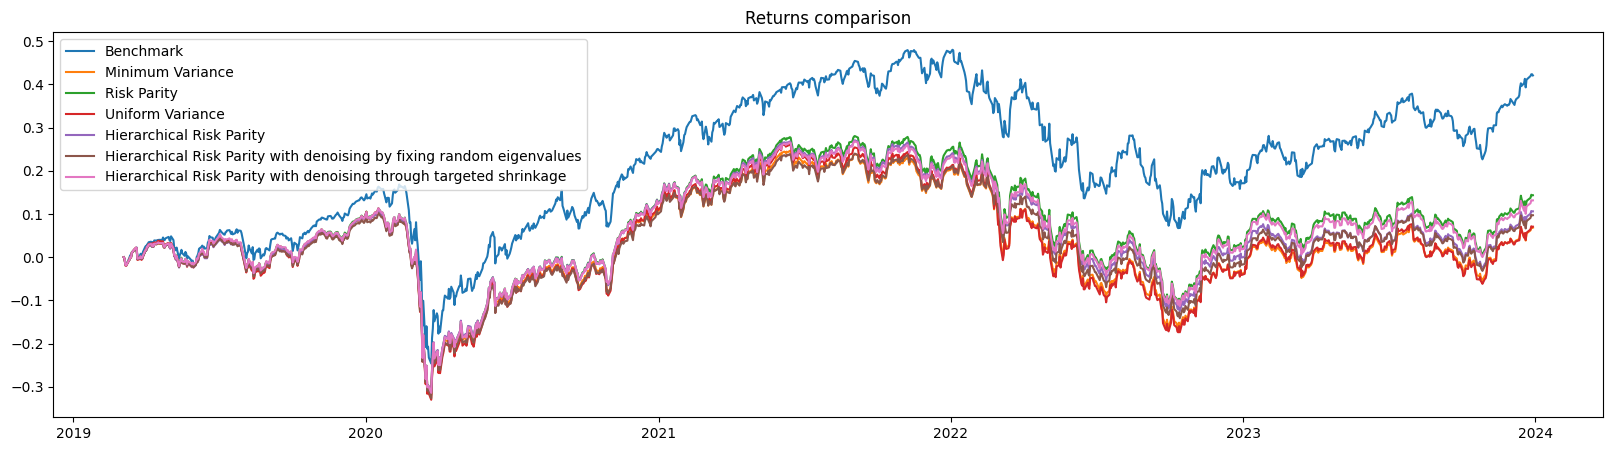

In [17]:
plt.figure(figsize=(20, 5))
plt.plot(cum_benchmark_returns, label='Benchmark')
plt.plot(cum_total_returns_min_var, label='Minimum Variance')
plt.plot(cum_total_returns_risk_parity, label='Risk Parity')
plt.plot(cum_total_returns_uniform_variance, label='Uniform Variance')
plt.plot(cum_total_returns_hrp, label='Hierarchical Risk Parity')
plt.plot(cum_total_returns_hrp_denoise_v1, label='Hierarchical Risk Parity with denoising by fixing random eigenvalues')
plt.plot(cum_total_returns_hrp_denoise_v2, label='Hierarchical Risk Parity with denoising through targeted shrinkage')
plt.legend()
plt.title('Returns comparison')
plt.show()

In [18]:
df_results = pd.DataFrame(columns=['Annual Returns', 
                                   'Annual Volatility',
                                   'Sharpe Ratio',
                                   'Sortino Ratio',
                                   'Max Drawdown',
                                   'Max Time Under Water',
                                   'Calmar Ratio',
                                   'Information Ratio'])

calculate_metrics(benchmark_returns, df_results, 'Benchmark')
calculate_metrics(total_returns_min_var, df_results, 'Minimum Variance', benchmark_returns)
calculate_metrics(total_returns_risk_parity, df_results, 'Risk Parity', benchmark_returns)
calculate_metrics(total_returns_uniform_variance, df_results, 'Uniform Variance', benchmark_returns)
calculate_metrics(total_returns_hrp, df_results, 'Hierarchical Risk Parity', benchmark_returns)
calculate_metrics(total_returns_hrp_denoise_v1, df_results, 'Hierarchical Risk Parity with denoising by fixing random eigenvalues', benchmark_returns)
calculate_metrics(total_returns_hrp_denoise_v2, df_results, 'Hierarchical Risk Parity with denoising through targeted shrinkage', benchmark_returns)

df_results

,Annual Returns,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Time Under Water,Calmar Ratio,Information Ratio
Benchmark,0.076754,0.203326,0.377494,0.442047,-0.354829,500.0,0.216313,0
Minimum Variance,0.013842,0.199493,0.069388,0.078476,-0.386418,641.0,0.035822,-0.933769
Risk Parity,0.02821,0.19853,0.142093,0.160722,-0.383822,583.0,0.073497,-0.763946
Uniform Variance,0.014284,0.212491,0.067222,0.076812,-0.397791,641.0,0.035909,-0.85055
Hierarchical Risk Parity,0.021174,0.196519,0.107748,0.12152,-0.380097,583.0,0.055708,-0.855866
Hierarchical Risk Parity with denoising by fixing random eigenvalues,0.019438,0.19698,0.098682,0.110608,-0.38895,583.0,0.049977,-0.887033
Hierarchical Risk Parity with denoising through targeted shrinkage,0.025996,0.196209,0.132492,0.1488,-0.383698,583.0,0.067751,-0.774503
